In [1]:
from collections import defaultdict
import numpy as np
from itertools import product
from scipy.special import gamma
from scipy.spatial.distance import pdist, squareform, euclidean
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.linear_model import LinearRegression
import math
from functions_for_clustering import *

In [ ]:
import itertools

def generate_subsequences(window, num, short=False):
    values = list(range(window))
    result = []
    if short:
        for subseq in itertools.combinations(values, num):
            diff = WINDOW - WINDOW_MIN
            result.append(tuple([num + diff for num in subseq]))
    else:
        for subseq in itertools.combinations(values, num):
            result.append(subseq)
    
    return result

In [8]:
WINDOW = 30

In [83]:
import numpy as np
PTS = 10

def gen_sample_in_point_with_q(values):
    sample = []
    flag = True
#     print(values)
    for i in range(1,len(values),2):
        
        if flag:
            sample.append(max(values[i - 1: i]))
        else:
            sample.append(min(values[i - 1: i]))
        flag = not flag
        kostyl = i
#     if (kostyl != len(values)):
#         sample.append(values[-1][0])
    if (len(sample) == WINDOW // 2):
        return sample[:-1]
    return sample

def predict_UsingQ_Simple(start_point, step, pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[2], pts))
    pred = sum(map(lambda center: center[0] * center[2], pts))
    return pred / sum_weight
    
def predict_UsingD_Simple(start_point, step, pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts))
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

def str_subseq(subseq):
    if not subseq:
        return '<None>'
    return ','.join(map(str, subseq))

In [129]:
from tqdm import trange, tqdm

def generate_predictions(centers, STEPS=5, return_set_pred=False, real_mode='test', EPS=3, Q_VALUE=0.99):
    preds = {}
    set_preds = {}

    if real_mode == 'test':
        end_point = 100 #val_end
        init_point = 70 #test_init
    else:
        end_point = train_end
        init_point = val_init
#мы двигаем окно PTS раз, для каждого окна у нас по ключу startpoint предскащания на STEPS шагов вперед 
#то есть в итоге у нас на выходе: {(startpoint, [predicted values for each step])}

    for start_point in tqdm(range(PTS)):
        preds[start_point] = [None] * (start_point + 1)
        if return_set_pred:
            set_preds[start_point] = [None] * (start_point + 1)

        
        wind = list(map(lambda x: (x, 1), xs[init_point + start_point : end_point + start_point]))

        #Здесь сначала в ряде ставим окно которое из которого семпл, (x,1 ) - здесь 1 - изначальное q-value для 
        #точки ряда, потом перемещая окно у нас уже другое q-value, которое где-то в самом низу считается (2)
        #на каждом шаге первого цикла мы снова его задаем с уже другой точкой изначальной ( двигаем на 1 по x)
        
 
        for step in range(1, STEPS + 1):
        #на каждом шаге этого цикла мы двигаем наше окно, добавляя предсказанную раньше точку вместе с qvalue туда
        #у каждой точки изначального ряда qvalue=1, дальше он уменьшается, видимо это отражает то что с каждым шагом меньше
        #гарантий что норм точка
            x_tests_for_point = {}
            counter = 0
            for pattern in patterns:

                key = counter
                counter += 1
                sample = gen_sample_in_point_with_q(np.concatenate([wind, [(0, 0)]]))
                if not sample:
                    x_tests_for_point[key] = None
                else:
                    x_tests_for_point[key] = sample
                    
                #Здесь короче x_tests_for_point = {} потом туда добавляем сэмпл из окна для каждого паттерна 
                #чтобы потом вес дать каждому изходя из мотива ( здесьэто centers типа центры кластеров)
           
            chosen_centers = []
            for pattern, centers_values in centers.items():
#                 if not x_tests_for_point[pattern]:
#                     continue
#                 print(x_tests_for_point)
                vector = np.array(x_tests_for_point[0])

                #q-values это какой-то параметр численный который тут сделан 1)) и который юзается для
                #q_weighted prediction типа там он вместе с расстоянием
              
            # def aggr_q(pts):
                    # weighted sum by q-value
                #    if not pts:
                 #   return None
                 #sum_weight = sum(map(lambda center: center[2], pts))
                #pred = sum(map(lambda center: center[0] * center[2], pts))
                 #   return pred / sum_weight
                    
                    
                q_values = np.array(x_tests_for_point[0][1])
                dist = euclidean(np.transpose(vector)[0], centers_values[:-1])
                

                #считаем расстояние между векторами для d-weighted предск
                if dist < EPS:
                    weight_d = (EPS - dist) / EPS
                    weight_q = np.mean(q_values) * Q_VALUE
                    #как я понял сначала у каждой точки которая точно в ряде вес 1, потом он уменьшается                         #у каждой новой добавленной точки  тк там значение предсказанное ( неточное -> вес<1)
                    chosen_centers.append((centers_values, weight_d, weight_q))
                    

            last_points = list(map(lambda center: (center[0][-1], center[1], center[2]), 
                                  chosen_centers))
            #лист вида[(последняя точка центра кластера, d вес, q вес, pattern)], такой формат хз почему
            
            # deamon predict
            result_point = predict_UsingD_Simple(start_point, step, last_points)
            preds[start_point].append(result_point)
            #тут мы добавляем средневзвешенное значение для точки t+step 
            #( типа предсказание, 2 типа - по расстоянию или qvalue) которые можно посмотреть в классе deamon

            if return_set_pred:
                set_preds[start_point].append(last_points)
            
            if result_point: # мы добавляем пару
                             #(predictedValue, qValue) когда  двигаемся по ряду (2)
                q_value = np.mean(np.array(list(map(lambda center: center[2], 
                                  chosen_centers))))
            else:
                q_value = None
            
            # тут мы двигаем окно дальше добавляя предсказанную точку и дальше ее используя в предсказании следующей
            #точки
            wind = np.concatenate([wind[1:], [(result_point, q_value)]])

   # deamon.predicted = True

    if return_set_pred:
        return preds, set_preds
    return preds
#возвращаем словарь вида {(точка начала: n предсказанных значений)} -> для каждой точки у нас много разных значений??

# В МОТИВАХ КЛЮЧ - ПАТТЕРН, ЗНАЧЕНИЕ МОТИФ

In [4]:
def get_motif(n1, n2):
    f = open('motifs/motif_%s_%s.txt' % (n1, n2), 'r')
    f.readline()
    s = f.readline()
    motif = list(map(float, s.split()))
    f.close()
    return motif



motifs = []
for i in range(6):
    for j in range(3):
        temp = get_motif(i, j)
        motifs.append(temp)

motifs
proper_motifs = {}
for i in range(len(motifs)): 
    proper_motifs[i] = motifs[i]


<class 'dict'>


In [6]:
f = open('motifs/all_motifs.txt', 'w')
for one_motif in motifs:
    f.write(' '.join(str(x) for x in one_motif))
    f.write('\n')
f.close()

In [5]:
patterns = [tuple([1] * 15)]
patterns

[(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)]

In [6]:
df = pd.read_csv('data/test/part_5.csv')
    
    #extracting data
df_temp = df.drop(labels=['Ticker', 'index', 'Date', 'extremum'], axis=1)
key1 = -15 #the number of ticks we wish to observe
key2 = min([int(x) for x in df_temp.columns])
df_temp = df_temp.drop(labels=[str(x) for x in list(range(key2,key1))], axis=1) #drop all ticks but those we're observing
df_temp = df_temp.dropna(axis=0) #drop rows with nan
clustering_data_trended = df_temp.values.tolist() #convert resulting data to list
clustering_data = detrend(clustering_data_trended) #detrend resulting data
    

In [7]:
df.head(10)

,Ticker,index,Date,extremum,-1,-2,-3,-4,-5,-6,...,-275,-276,-277,-278,-279,-280,-281,-282,-283,-284
0,VYRLX,22.0,2020-03-23,0.0,0.033382,0.064677,0.062591,0.148131,0.106404,0.256621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,VYRLX,300.0,2021-04-29,1.0,0.993277,0.993277,0.993277,0.988796,0.968628,0.979832,...,0.198203,0.123095,0.093886,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VYRMX,22.0,2020-03-23,0.0,0.029372,0.062270,0.049346,0.124539,0.075194,0.224406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VYRMX,300.0,2021-04-29,1.0,0.993593,0.993593,0.993593,0.987186,0.961558,0.973090,...,0.190334,0.124539,0.096342,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,VYRNX,22.0,2020-03-23,0.0,0.033034,0.055903,0.068608,0.162626,0.139757,0.279514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,VYRNX,300.0,2021-04-29,1.0,0.994652,0.994652,0.994652,0.991978,0.975933,0.983955,...,0.193119,0.111806,0.081313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,VYROX,22.0,2020-03-23,0.0,0.031554,0.064481,0.057621,0.138564,0.093291,0.242830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,VYROX,300.0,2021-04-29,1.0,0.993955,0.992444,0.992444,0.987911,0.965243,0.975821,...,0.193441,0.123473,0.096035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,VYRPX,22.0,2020-03-23,0.0,0.034805,0.053790,0.082268,0.183521,0.183521,0.310087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,VYRPX,300.0,2021-04-29,1.0,0.993336,0.993336,0.996668,0.993336,0.980009,0.983341,...,0.180357,0.088596,0.063283,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

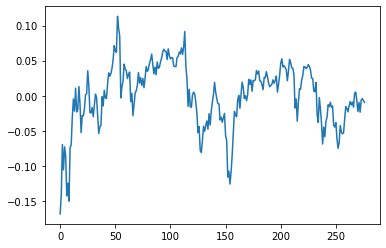

In [113]:
df = pd.read_csv('data/test/part_5.csv')
df_pred = df.loc[df.index == 1]
df_pred = df_pred.drop(labels=['Ticker', 'index', 'Date', 'extremum'], axis=1)
df_pred = df_pred.dropna(axis=1)

xs_temp = df_pred.values.tolist()
xs = detrend(xs_temp)
xs = list(np.array(xs).flatten())
xs = xs[::-1]
sns.lineplot(y=xs, x=list(range(len(xs))))


In [127]:
predicted_points = generate_predictions(proper_motifs, 1)
predicted_points

100%|██████████| 10/10 [00:00<00:00, 690.83it/s]


{0: [None, -0.042449704488069416],
 1: [None, None, -0.042449704488069395],
 2: [None, None, None, -0.04244970448806941],
 3: [None, None, None, None, -0.0424497044880694],
 4: [None, None, None, None, None, -0.04244970448806939],
 5: [None, None, None, None, None, None, -0.042449704488069395],
 6: [None, None, None, None, None, None, None, -0.04244970448806939],
 7: [None, None, None, None, None, None, None, None, -0.04244970448806938],
 8: [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  -0.042449704488069395],
 9: [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  -0.04244970448806938]}

[-0.042449704488069416]
[-0.042449704488069395]
[-0.04244970448806941]
[-0.0424497044880694]
[-0.04244970448806939]
[-0.042449704488069395]
[-0.04244970448806939]
[-0.04244970448806938]
[-0.042449704488069395]
[-0.04244970448806938]


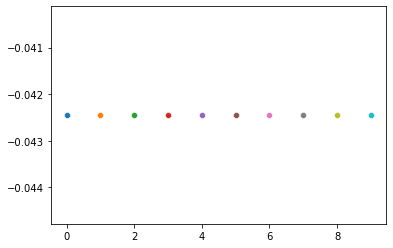

In [128]:
for x in predicted_points.items():
    start_point, predicted_values = x[0], x[1]
    predicted_values = list(filter(None, predicted_values))
    print(predicted_values)
    sns.scatterplot(y=predicted_values, x=start_point)